## Imports

In [81]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from torchvision.datasets import CocoDetection
from transformers import DetrImageProcessor
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import AdamW
from transformers import DetrForObjectDetection

## Dataset

In [82]:
class SeatbeltCocoDataset(CocoDetection):
    
    def __init__(self, img_folder, processor):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(SeatbeltCocoDataset, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(SeatbeltCocoDataset, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [83]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = SeatbeltCocoDataset(img_folder='./data/train', processor=processor)
val_dataset = SeatbeltCocoDataset(img_folder='./data//valid', processor=processor)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [84]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 2433
Number of validation examples: 231


Image n°738


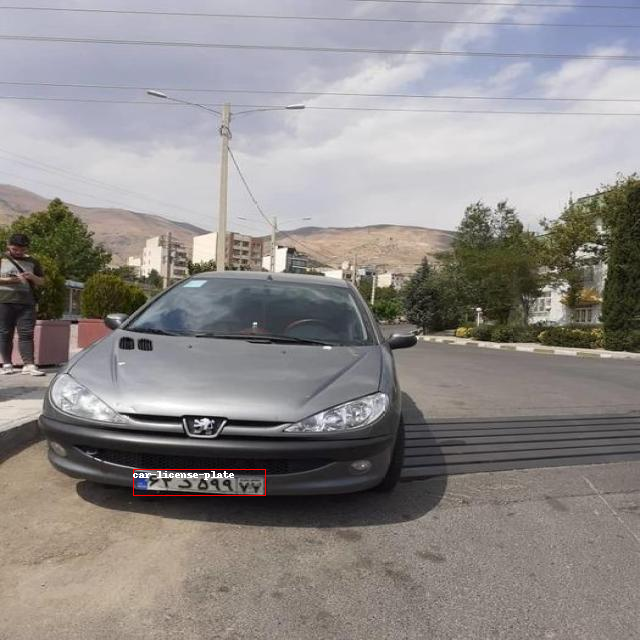

In [85]:
# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('./data/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [86]:
print(id2label)

{0: 'car license plate_detection', 1: 'car-license-plate'}


In [87]:
pixel_values, target = train_dataset[0]

In [88]:
pixel_values.shape

torch.Size([3, 800, 800])

In [89]:
print(target)

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([1]), 'boxes': tensor([[0.4270, 0.5031, 0.3883, 0.1562]]), 'area': tensor([38828.1250]), 'iscrowd': tensor([0]), 'orig_size': tensor([640, 640])}


In [90]:
def collate_fn(batch):
  
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  
  return batch

In [91]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

In [92]:
batch = next(iter(train_dataloader))
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

## Model

In [93]:
# Define your model
lr = 0.0001
lr_backbone = 0.00001
weight_decay = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True).to(device)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

In [95]:
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:

        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss  # Access the loss from the outputs object

        # loss_dict = outputs.loss_dict

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_dataloader)}")

    # Validation loop
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
    
        for batch in val_dataloader:
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask = batch["pixel_mask"].to(device)
            labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
            loss = outputs.loss  # Access the loss from the outputs object

            total_val_loss += loss.item()

    print(f"Validation Loss: {total_val_loss / len(val_dataloader)}")

Epoch 1, Training Loss: 1.2610348923550843
Validation Loss: 0.8776374325670045


KeyboardInterrupt: 

## Save Model

In [96]:
path = './saved_model.pth'
torch.save(model, path)

## Evaluation

In [97]:
test_dataset = SeatbeltCocoDataset(img_folder='./data/test', processor=processor)
pixel_values, target = test_dataset[9]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [98]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 800])


In [99]:
with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
    
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [100]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [101]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [102]:
id2label

{0: 'car license plate_detection', 1: 'car-license-plate'}

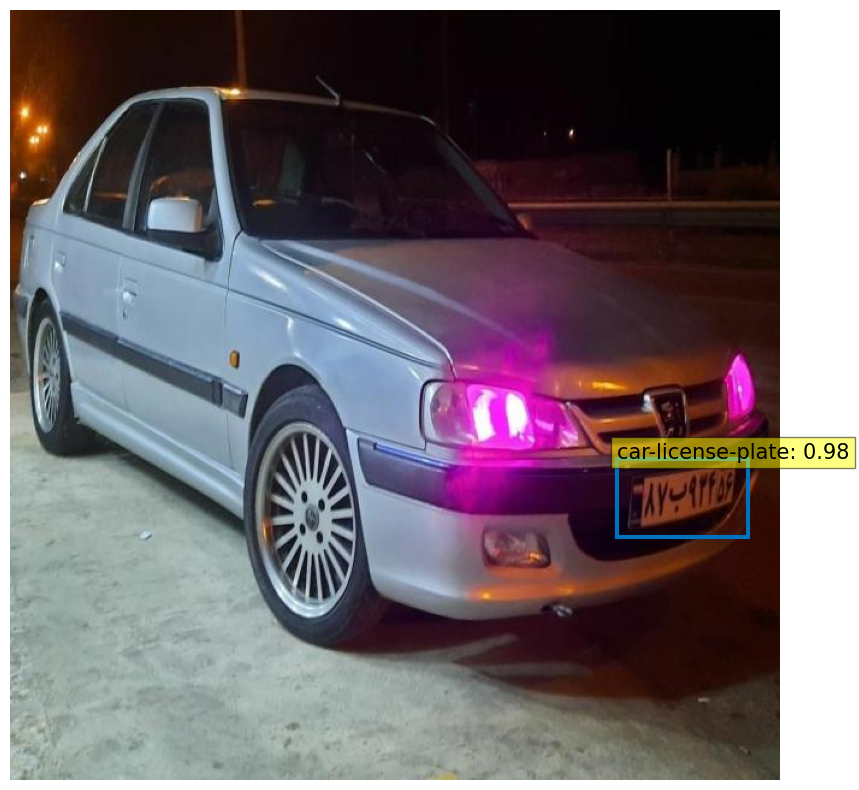

In [104]:
# load image based on ID
image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('./data/test', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.7)

results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])